In [647]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

from pyDOE import lhs
from scipy.stats import uniform,norm


import os
import re


os.chdir("/home/s2113174/Projects-1")

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Making the data for an Inverse Problem following the parametric ODE

$$\frac{du}{dt} - \alpha cos(2\pi t)=0$$

with solution 
$$ u(t) = \alpha \frac{sin ( 2 \pi t )}{2 \pi} + 1$$

## The Problem consist in infering $ \alpha $

Text(0, 0.5, 'Observations')

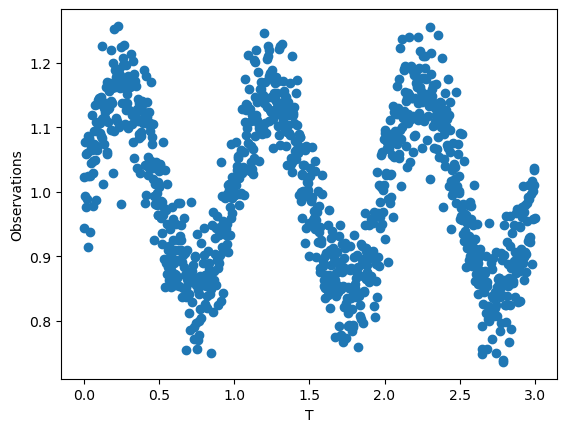

In [479]:
ns = 3
t= np.linspace(0,ns,1000)
mean, std = 0,0.05

Exact = (1/ (2*np.pi))*np.sin(2*np.pi*t)+1

noise_sol = Exact + np.random.normal(mean,std, len(t))

plt.scatter(t,noise_sol)
plt.xlabel("T")
plt.ylabel("Observations")


## Feed Forward Neural Network

In [480]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## Parametric PINN for Inverse Problems

In [481]:
def DE(self,t,pr):
    """ The pytorch autograd version of calculating residual """
    u = self(torch.cat([t, pr], dim=1))
    
    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    
    f = u_t - pr*torch.cos( 2*torch.pi *t)
    return f

In [482]:
DNN.DE = DE

In [483]:
def sample_ic(size):
    return np.zeros(size)

def samples_space(size,maxl):
    t_f_train = lhs(1, size)*maxl
    return t_f_train

def samples_param(min,max,size):
    return np.random.random(min - 1,max + 1,size = size)

In [484]:
def train(epochs, pinn,loss,optimizer,size,maxl,minp,maxp):
   
   print("Starting Training")

   #for epoch in range(epochs):
   itr_loss = 0.0   

   for i in range(epochs):

    ic, t, param = sample_ic(size),samples_space(size,maxl),samples_param(minp,maxp,size)

    ic, t, param = torch.tensor(ic).float().to(device), torch.tensor(t).float().to(device), torch.tensor(param).float().to(device)

    ic, t, param = Variable(ic,requires_grad=True).reshape(-1,1), Variable(t,requires_grad=True).reshape(-1,1), Variable(param,requires_grad=True).reshape(-1,1)

       
    def loss_func_train():
        
        optimizer.zero_grad()

        ic_pred,f_pred = pinn(torch.cat([ic, param], dim=1)),pinn.DE(t,param)

        loss_u_ic,loss_f = loss(ic_pred,torch.ones_like(t)),loss(f_pred,torch.zeros_like(t))

        Loss =  loss_f + loss_u_ic

        if i % 10 == 0:
                print('Iter %d, Loss: %.5e, Loss_ic: %.5e, Loss_f: %.5e' % (i, Loss.item(), loss_u_ic.item(), loss_f.item()))
           
        Loss.backward() 
    
        return Loss

    optimizer.step(loss_func_train) 
    
    oupt = pinn(torch.cat([ic, param], dim=1))  

    loss_val = loss_func_train() 

    itr_loss += loss_val.item()  

In [485]:
# Number of observations
epochs = 100
nobs = 1000
lr = 0.01

min_param , max_param = 1, 8

space = 3

layers = [2] + 5*[50] + [1]

In [486]:
model = DNN(layers)

In [487]:
loss = torch.nn.MSELoss(reduction ='mean')

optimizer = torch.optim.LBFGS(
    model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" 
    )

#optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [488]:
train(epochs, model,loss,optimizer,nobs,space,min_param , max_param)

Starting Training
Iter 0, Loss: 1.22753e+01, Loss_ic: 1.39373e+00, Loss_f: 1.08816e+01
Iter 0, Loss: 1.22744e+01, Loss_ic: 1.39284e+00, Loss_f: 1.08816e+01
Iter 0, Loss: 1.22664e+01, Loss_ic: 1.38488e+00, Loss_f: 1.08816e+01
Iter 0, Loss: 1.21879e+01, Loss_ic: 1.30654e+00, Loss_f: 1.08814e+01
Iter 0, Loss: 1.15376e+01, Loss_ic: 6.57500e-01, Loss_f: 1.08801e+01
Iter 0, Loss: 1.15195e+01, Loss_ic: 6.39393e-01, Loss_f: 1.08801e+01
Iter 0, Loss: 1.13636e+01, Loss_ic: 4.84019e-01, Loss_f: 1.08796e+01
Iter 0, Loss: 1.08926e+01, Loss_ic: 1.48979e-02, Loss_f: 1.08777e+01
Iter 0, Loss: 1.08926e+01, Loss_ic: 1.48711e-02, Loss_f: 1.08777e+01
Iter 0, Loss: 1.08924e+01, Loss_ic: 1.47523e-02, Loss_f: 1.08777e+01
Iter 0, Loss: 1.08918e+01, Loss_ic: 1.41444e-02, Loss_f: 1.08777e+01
Iter 0, Loss: 1.08917e+01, Loss_ic: 1.40509e-02, Loss_f: 1.08777e+01
Iter 0, Loss: 1.08914e+01, Loss_ic: 1.37505e-02, Loss_f: 1.08776e+01
Iter 0, Loss: 1.08882e+01, Loss_ic: 1.07467e-02, Loss_f: 1.08774e+01
Iter 0, Loss: 1.

In [490]:
def test_set(max_space,obs,param,mean,std):

    t= np.linspace(0,max_space,obs)

    sol = (param/ (2*np.pi))*np.sin(2*np.pi*t)+1

    noise_sol_test = sol + np.random.normal(mean,std, len(t))

    return t, noise_sol_test

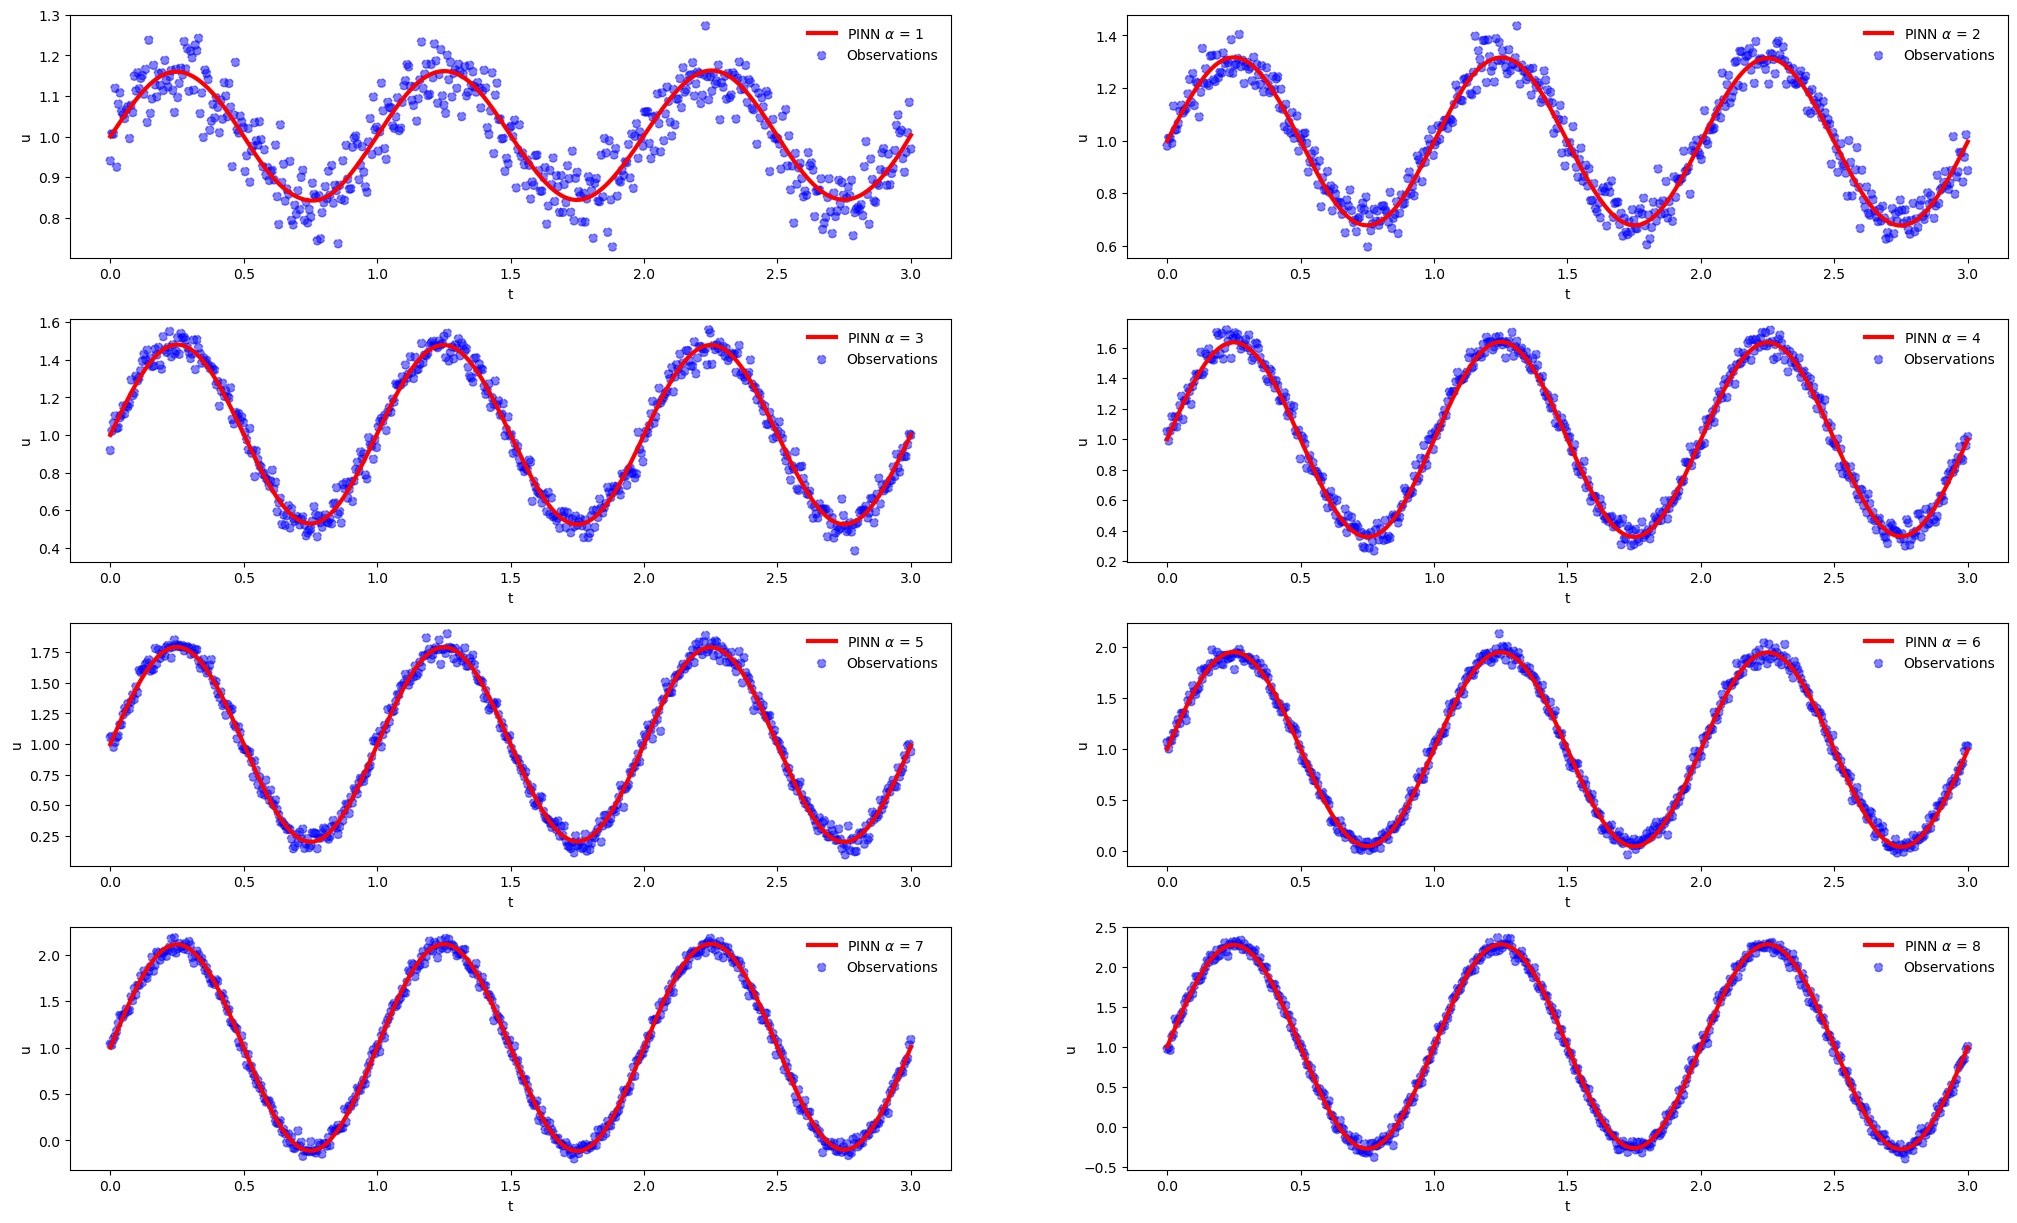

In [492]:
import matplotlib.pyplot as plt
from matplotlib import cm


# Plotting
fig = plt.figure(figsize=(25,15))
plt.subplots_adjust(hspace=0.25)

for n in range(max_param):

    t, noise_sol_test = test_set(ns,500,n + 1,mean,std)

    data_test = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(n + 1)))
    u_pred = model(torch.tensor(data_test).float()).detach().cpu().numpy()

    u_pred = model(torch.tensor(data_test).float()).detach().cpu().numpy()

    plt.subplot(4, 2, n + 1)

    plt.plot(t, u_pred, label = fr"PINN $\alpha$ = {n + 1}", color = "red",linewidth = '3')

    plt.scatter(t,noise_sol_test,linestyle='dashed', label = "Observations",color= "blue",alpha = 0.5)

    plt.xlabel("t")
    plt.ylabel("u")
    plt.legend(frameon=False)

In [495]:
t, noise_sol_test = test_set(ns,500,3.5,mean,std)

In [667]:
def prior_alpha(alpha): #function to evaluate prior pdf of given parameters
    return np.log(norm.pdf(alpha,3,2))
#
def prior_sig(sig): #function to evaluate prior pdf for sigma^2
    return np.log(uniform(loc=0.,scale=1).pdf(sig))

def proposals(alpha,sig):
    _alpha = alpha + np.random.normal(0,1,1)
    _sig = sig + np.random.normal(0,1,1)
    return _alpha, _sig

In [668]:
def log_likelihood(surrogate,alpha,sig,t,y_dat):
    
    data_ = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(alpha)))

    surg = surrogate(torch.tensor(data_).float()).detach().cpu().numpy()

    log_l = np.sum(-np.log(np.sqrt(2* np.pi*sig)) - ((y_dat-surg)**2) / (2*sig**2))
        
    return log_l

In [669]:
def Metropolis_Hastings(t,y_dat,nChains):

    alpha = np.random.randint(6,size = 1)
    sigma=np.random.random()

    alpha_samp,sigma_samp = [], []

    for i in range(nChains):

        log_lik = log_likelihood(model,alpha,sigma,t,y_dat)
        log_posterior = prior_alpha(alpha) + prior_sig(sigma) + log_lik


        alpha_proposal , sigma_proposal = proposals(alpha,sigma)

        log_lik_propsal = log_likelihood(model,alpha_proposal,sigma_proposal,t,y_dat)
        log_posterior_proposal = prior_alpha(alpha_proposal) + prior_sig(sigma_proposal) + log_lik_propsal

        accept_u = np.random.rand()

        ratio = np.exp(log_posterior_proposal-log_posterior)


        a = np.min([1.,ratio[0]])

        if accept_u <= a:
            alpha, sigma = alpha_proposal , sigma_proposal
            
        alpha_samp.append(alpha)
        sigma_samp.append(sigma)

    return alpha_samp,sigma_samp

In [670]:
alpha_samp,sigma_samp = Metropolis_Hastings(t,noise_sol_test,100000)

/tmp/ipykernel_5164/681329383.py:21: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(log_posterior_proposal-log_posterior)
/tmp/ipykernel_5164/2426388371.py:7: RuntimeWarning: invalid value encountered in sqrt
  log_l = np.sum(-np.log(np.sqrt(2* np.pi*sig)) - ((y_dat-surg)**2) / (2*sig**2))
/tmp/ipykernel_5164/4204319232.py:5: RuntimeWarning: divide by zero encountered in log
  return np.log(uniform(loc=0.,scale=1).pdf(sig))


(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]),
 array([-0.51382059, -0.35398136, -0.19414213, -0.0343029 ,  0.12553633,
         0.28537556,  0.4452148 ,  0.60505403,  0.76489326,  0.92473249,
         1.08457172]),
 <a list of 16 BarContainer o

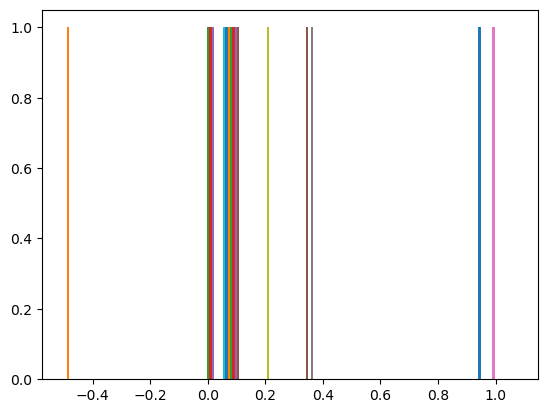

In [671]:
plt.hist(alpha_samp)